In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Acoustic_Extinguisher_Fire_Dataset.csv')
cols = df.columns
df

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [4]:
df['FUEL'] = encoder.fit_transform(df['FUEL'])
df

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,0,10,96,0.0,75,0
1,1,0,10,96,0.0,72,1
2,1,0,10,96,2.6,70,1
3,1,0,10,96,3.2,68,1
4,1,0,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,2,190,86,2.2,5,0
17438,7,2,190,84,2.0,4,0
17439,7,2,190,80,1.5,3,0
17440,7,2,190,76,0.4,2,0


In [5]:
def split(VAR,data):
    lst  = sorted(list(df[VAR]))
    m1 = int(len(lst)/3)
    m2 = int(m1 + len(lst)/3)
    v1 = lst[m1]
    v2 = lst[m2]

    def change(x):
        if x<v1:
            return 1
        elif x<v2:
            return 2
        else:
            return 3
    data [VAR] = data[VAR].apply(change)
    return data

In [6]:
def continuous(data):
    for i in cols:
        if len(data[i].unique()) > 10:
            data = split(i,data)
    return data

In [7]:
df = continuous(df)
df

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,0,1,2,1,3,0
1,1,0,1,2,1,3,1
2,1,0,1,2,1,3,1
3,1,0,1,2,1,3,1
4,1,0,1,3,2,3,1
...,...,...,...,...,...,...,...
17437,7,2,3,1,1,1,0
17438,7,2,3,1,1,1,0
17439,7,2,3,1,1,1,0
17440,7,2,3,1,1,1,0


In [8]:
df.dtypes

SIZE         int64
FUEL         int32
DISTANCE     int64
DESIBEL      int64
AIRFLOW      int64
FREQUENCY    int64
STATUS       int64
dtype: object

In [9]:
def entropy(x):
    probs=x.value_counts(normalize=True)
    entropy=-np.sum(probs*np.log2(probs))
    return entropy

In [10]:
def gain(data, split, target):
    total_entropy = entropy(data[target])
    subset_entropy = 0
    for i in data[split].unique():
        subset = data[data[split]==i]
        subset_entropy += (len(subset)/len(data))*entropy(subset[target])
    gain = total_entropy - subset_entropy
    return gain

In [22]:
def fit(data, target, depth=0, max_depth=2):
    if len(data.columns)==1 or depth == max_depth:
        return data[target].mode()[0]
    else:
        gains = []
        for i in data.columns:
            if i!=target:
                gains.append(gain(data,i,target))

        split_variable = data.columns[np.argmax(gains)]
        tree = {}
        tree['Split_variable'] = split_variable
        tree['depth'] = depth
        
        for category in data[split_variable].unique():
            subset=data[data[split_variable]==category].drop(split_variable,axis=1)
            subtree=fit(subset,target,depth=depth+1,max_depth=max_depth)
            tree[category]=subtree
        return tree

In [23]:
def predict_one(x,tree):
    col = df.columns
    while(True):
        var = tree['Split_variable']
        for i in range(len(col)):
            if col[i] == var:
                ind = i
        val = x[ind]
        if str(type(tree[val])) == "<class 'dict'>":
            tree = tree[val]
        else:
            return tree[val]

In [24]:
def predict(X,tree):
    test = np.array(X)
    a = []
    for i in test:
        a.append(predict_one(i,tree))
    return a

In [25]:
X = df.iloc[:,:6]
Y = df.iloc[:,6]

In [26]:
from sklearn.model_selection import train_test_split 

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [28]:
# concatenating data frame for test set
data = pd.concat([X_train, Y_train], axis=1, ignore_index=True)
data.columns = df.columns
data

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
4635,5,0,2,1,2,1,0
16958,7,2,2,2,1,3,0
1595,2,0,2,3,2,2,1
13136,3,1,3,2,1,3,0
9384,5,3,1,1,3,1,1
...,...,...,...,...,...,...,...
3768,4,0,3,2,2,1,0
14797,5,1,2,2,1,3,0
1785,2,0,3,2,1,3,0
13401,4,1,1,3,3,3,1


In [29]:
tree = fit(df,df.columns[6])
print(tree)

{'Split_variable': 'AIRFLOW', 'depth': 0, 1: {'Split_variable': 'SIZE', 'depth': 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}, 2: {'Split_variable': 'SIZE', 'depth': 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0}, 3: {'Split_variable': 'DISTANCE', 'depth': 1, 1: 1, 2: 1}}


In [19]:
Y_pred = predict(X_test,tree)
Y_pred

[1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,


In [20]:
from sklearn.metrics import accuracy_score
print(f"Accuracy : {accuracy_score(Y_test, Y_pred)*100:.2f} %")

Accuracy : 91.36 %


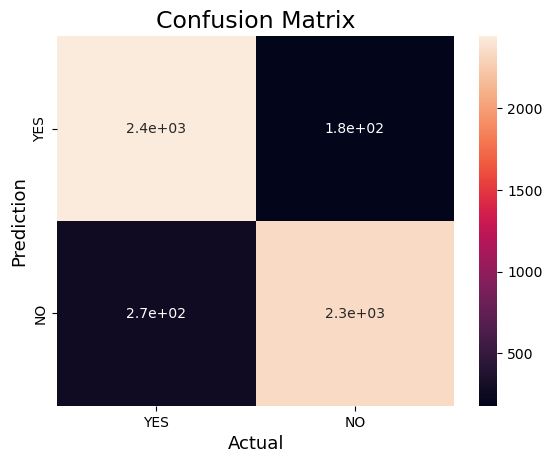

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm,
            annot=True,
            xticklabels=['YES','NO'],
            yticklabels=['YES','NO'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()